# Logistic regression

## Reading Murphy 2.4.2

Let's return to the lobster problem, but this time, we'll take an alternative approach that doesn't rely so much on hypothesized distributions.  First, the data:

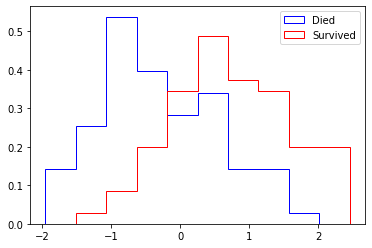

In [1]:
import numpy as np
import matplotlib.pyplot as plt
data = np.loadtxt('lobster_survive.dat',skiprows=1)
X,Y = data.T
X -= X.mean()
X /= X.std()

bins = np.unique(X)
plt.hist(X[Y==0],bins,histtype='step',density=True,label='Died',color='blue')
plt.hist(X[Y==1],bins,histtype='step',density=True,label='Survived',color='red')
plt.legend()
plt.show()

We would still like to know
$$
P(Y=1|X=x),
$$
where $Y$ is a variable indicating whether the lobster survived or not, and $X$ is the length of the lobster ($x\in\mathcal{R}$).  

To begin, let's recall the Bayesian classifier:
$$
P(Y=1|X=x) = \frac{P(X=x|Y=1)P(Y=1)}{P(X=x|Y=1)P(Y=1) + P(X=x|Y=0)P(Y=0)}
$$
We notice that the first term in the denominator is the same as the numerator.  We can factor in terms of this term to get
$$
P(Y=1|X=x) = \frac{1}{1 + \frac{P(X|Y=0)P(Y=0)}{P(X|Y=1)P(Y=1)}}.
$$
Thus we see that the probability of survival is given by the odds of the prior and the likelihood (and not the evidence at all).  Note that this is true regardless of the choices of distribution.  The odds are a bit awkward to work with because they're assymetrical: the odds of survival to death might be 2, while the converse is 1/2.  It's easier to work with a quantity where these quantities are symmetric.  Taking the logarithm of the odds does this because $\ln(2) = -\ln(\frac{1}{2})$.  Defining the log-odds as 
$$
z = \frac{P(X|Y=1)P(Y=1)}{P(X|Y=0)P(Y=0)},
$$
we can write the posterior probability as 
$$
P(Y=1|X=x) = \frac{1}{1+\mathrm{exp}(-z)}.
$$
This function is called the *logistic function* or *sigmoid*.  We can implement this easily as:

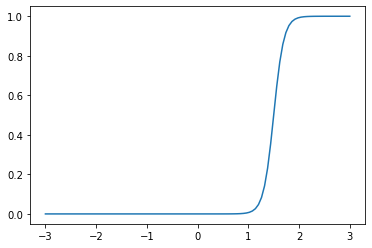

In [2]:
def sigmoid(z):
    return 1./(1+np.exp(-z))

z = np.linspace(-3,3,101)
plt.plot(z, sigmoid(z*10-15))

If we make the same assumptions of normality of the features that we made for the Bayesian classifier, we can write down the log-odds explicitly in terms of the parameters of that model.  If we collect terms, we can write the log-odds as a function of $x$
$$
z = w_0 + w_1 x + w_2 x^2
$$
where
$$
w_0 = \theta + (1-\theta) - \frac{1}{2}(\sigma_0^2 - \sigma_1^2) - \frac{1}{2}\left(\frac{\mu_0^2}{\sigma_0^2} - \frac{\mu_1^2}{\sigma_1^2}\right)
$$
$$
w_1 = \left(\frac{\mu_1}{\sigma_1^2} - \frac{\mu_0}{\sigma_0^2}\right)
$$
$$
w_2 = \frac{1}{2}\left(\frac{1}{\sigma_1^2} - \frac{1}{\sigma_0^2} \right).
$$
This function is interesting because the classifier has a fairly simple functional form: a quadratic function of $x$ run through the logistic function.  The only place that the assumptions of distributions enter into the calculation is in the specification of the coefficients of that polynomial function.  This suggests an alternative approach.  How about instead of computing the parameters $w_0$, $w_1$, and $w_2$ by fitting normal distributions, we take them as unknowns and find them directly?  

In fact, let's simplify the problem by dropping the quadratic term and making the hypothesis that 
$$
P(Y=1|X=x) = \frac{1}{1 + \exp({-(w_0 + w_1 x)})} = \sigma(w_0 + w_1 x)
$$
Now, given some set of training data $\mathbf{X}_{obs}$ and $\mathbf{Y}_{obs}$, we can use Bayes' theorem to find the distribution over $w_0,w_1$
$$
P(w_0,w_1 | \mathbf{X}_{obs},\mathbf{Y}_{obs}) \propto P(\mathbf{Y}_{obs}|w_0,w_1,\mathbf{X}_{obs}) P(w_0,w_1)
$$
Now our goal is to maximize this function with respect to both $w_0$ and $w_1$.  As usual it will be more useful to maximize the logarithm.  

In [3]:
w = np.array([0.0,1.0])
def L(w,X,Y):
    z = w[0] + w[1]*X
    s = sigmoid(z)
    L_ = Y*np.log(s) + (1-Y)*np.log(1-s)
    return L_.sum(axis=0)

L(w,X,Y)

-87.56252932234597

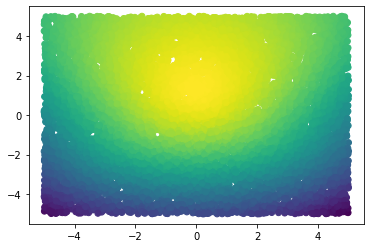

In [4]:
L_list = []
w_list = []
n_samples = 10000
for i in range(n_samples):
    w = (np.random.rand(2)*2 - 1)*5
    L_list.append(L(w,X,Y))
    w_list.append(w)

w = np.array(w_list)
plt.scatter(*w.T, c = L_list)

Using either a grid-search approach (check out numpy.meshgrid) or a random sampling approach, search for the values of $\mathbf{w}$ that maximizes this likelihood function.  Plot all computed values of $\mathcal{L}(\mathbf{w})$ as a function of $\mathbf{w}$.  Useful commands for this plotting if you take the grid search approach might be plt.contourf.  For the random sampling approach, you might try plt.scatter (using the c= keyword argument).


Text(0.25, 1.3200000000000003, '0.0, 1.3200000000000003')

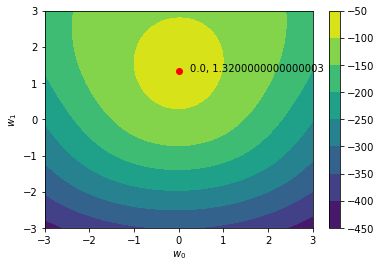

In [5]:
# Develop a method to find the best values of w_0 and w_1.  

# Define grid points for each parameter in 1D
n_samples = 51
w_0_range = np.linspace(-3,3,n_samples)
w_1_range = np.linspace(-3,3,n_samples)

# Take the cartesian product of these grid points
w_0,w_1 = np.meshgrid(w_0_range,w_1_range)

L_grid = np.zeros_like(w_0)
for i in range(n_samples):
    for j in range(n_samples):
        L_grid[i,j] = L([w_0[i,j],w_1[i,j]],X,Y)

plt.contourf(w_0,w_1,L_grid)
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.colorbar()


best_indices = np.unravel_index(L_grid.argmax(), L_grid.shape)
w_best = np.array([w_0[best_indices],w_1[best_indices]])

plt.plot(w_best[0],w_best[1],'ro')
plt.text(w_best[0]+0.25,w_best[1],f'{w_best[0]}, {w_best[1]}')

Using this best parameter set, plot lobster survival as a function of length.  

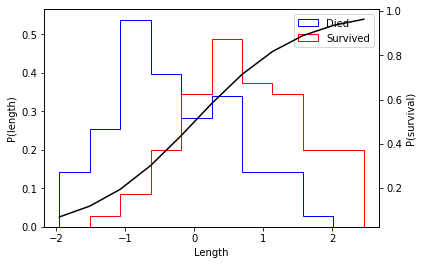

In [6]:
plt.hist(X[Y==0],bins,histtype='step',density=True,label='Died',color='blue')
plt.hist(X[Y==1],bins,histtype='step',density=True,label='Survived',color='red')
plt.ylabel('P(length)')
plt.xlabel('Length')
plt.legend()

plt.twinx()
plt.plot(X,sigmoid(w_best[0] + w_best[1]*X),'k-')
plt.ylabel('P(survival)')

plt.show()

In [7]:
def L(w,X,Y):
    z = w[0] + w[1]*X
    s = sigmoid(z)
    L_ = Y*np.log(s) + (1-Y)*np.log(1-s)
    return -L_.sum(axis=0)

def L_grad(w,X,Y):
    Phi = np.ones((len(X),2))
    Phi[:,1] = X
    return -((Y - sigmoid(Phi @ w))[:,np.newaxis]*Phi).sum(axis=0)

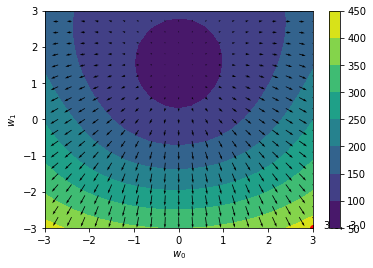

In [8]:
# Develop a method to find the best values of w_0 and w_1.  

# Define grid points for each parameter in 1D
n_samples = 21
w_0_range = np.linspace(-3,3,n_samples)
w_1_range = np.linspace(-3,3,n_samples)

# Take the cartesian product of these grid points
w_0,w_1 = np.meshgrid(w_0_range,w_1_range)

L_grid = np.zeros_like(w_0)
for i in range(n_samples):
    for j in range(n_samples):
        L_grid[i,j] = L([w_0[i,j],w_1[i,j]],X,Y)

plt.contourf(w_0,w_1,L_grid)
plt.xlabel('$w_0$')
plt.ylabel('$w_1$')
plt.colorbar()


best_indices = np.unravel_index(L_grid.argmax(), L_grid.shape)
w_best = np.array([w_0[best_indices],w_1[best_indices]])

plt.plot(w_best[0],w_best[1],'ro')
plt.text(w_best[0]+0.25,w_best[1],f'{w_best[0]}, {w_best[1]}')

L_grad_0 = np.zeros_like(w_0)
L_grad_1 = np.zeros_like(w_1)
for i in range(n_samples):
    for j in range(n_samples):
        g = L_grad([w_0[i,j],w_1[i,j]],X,Y)
        L_grad_0[i,j] = g[0]
        L_grad_1[i,j] = g[1]
        
plt.quiver(w_0,w_1,L_grad_0,L_grad_1)

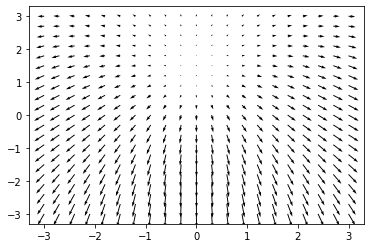

In [9]:
plt.quiver(w_0,w_1,L_grad_0,L_grad_1)

In [11]:
# L_grad_1